In [1]:
# import libraries
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from joblib import dump
from keras import regularizers
from keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing
import matplotlib
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Dropout
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

Using TensorFlow backend.


In [2]:
df = pd.read_excel('Data2017.xlsx')
# df.head()

In [3]:
df1=df

In [4]:
df.index = pd.to_datetime(df['Data'], format='%Y.%m.%d.%H.%M.%S')

In [5]:
df = df.drop('Data',1)

In [6]:
df = df.abs()

In [7]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
count,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,...,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000,14754.000000
mean,48.278645,673.639484,962.292946,173.697809,51.509626,39.559624,65.623637,231.677690,6.531774,0.686508,...,9.513641,10.539554,13.831001,55.763570,41.696799,30.386897,28.360352,0.238153,0.156347,0.163244
std,5.348811,51.228860,105.423560,9.592973,5.591927,5.085898,4.047867,25.022544,0.150703,0.083548,...,1.117822,1.137451,1.203659,1.674757,1.602571,1.317695,1.095412,0.028447,0.008211,0.024115
min,1.100000,118.335876,0.358584,1.329598,22.392895,6.471906,0.000000,177.685547,3.441034,0.100876,...,0.228938,0.549451,0.000000,0.045788,0.457875,0.824176,0.274725,0.092186,0.039683,0.070818
25%,50.390842,647.282654,999.458939,172.065472,47.213017,34.998879,64.714729,228.306366,6.446196,0.643537,...,9.111722,10.027473,13.273712,55.082420,40.784077,29.684193,27.884617,0.220391,0.151404,0.148962
50%,50.481819,676.846558,1000.376678,175.701324,50.457277,35.544184,66.187290,235.817352,6.527050,0.695572,...,9.294872,10.290683,13.644689,55.906597,41.804028,30.410461,28.434067,0.238706,0.157509,0.163004
75%,50.541142,704.646759,1009.909454,178.990044,54.666754,44.980857,67.629154,242.384438,6.610173,0.744966,...,9.514585,10.628195,14.069069,56.598605,42.628204,31.144665,28.983517,0.257021,0.161783,0.178877
max,52.499310,842.905823,1110.950195,195.123978,69.077850,54.838787,92.866989,861.841675,7.421791,0.900253,...,37.419235,25.228939,48.183426,58.653851,47.531506,35.984642,31.227106,0.326007,0.178266,0.234432


In [8]:
df.mean()

X1       48.278645
X2      673.639484
X3      962.292946
X4      173.697809
X5       51.509626
X6       39.559624
X7       65.623637
X8      231.677690
X9        6.531774
X10       0.686508
X11    3906.056550
X12     109.887216
X13      29.323771
X14       6.422416
X15       8.892011
X16      19.312515
X17       9.792665
X18       9.513641
X19      10.539554
X20      13.831001
X21      55.763570
X22      41.696799
X23      30.386897
X24      28.360352
X25       0.238153
X26       0.156347
X27       0.163244
dtype: float64

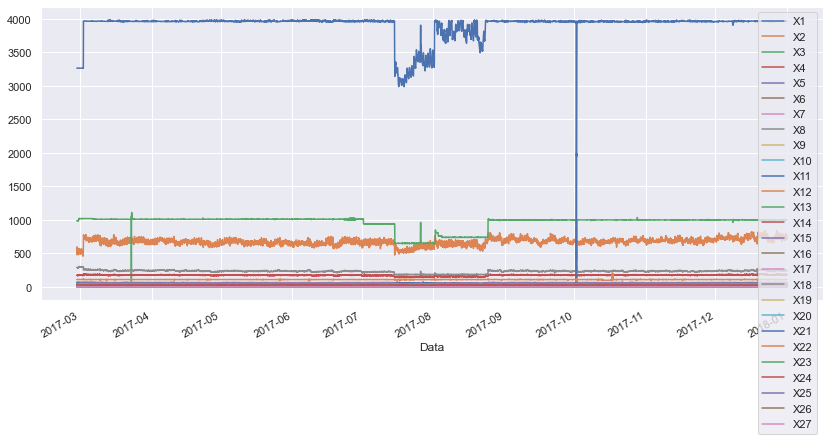

In [9]:
 df.plot(figsize = (14,6))

In [59]:
train = df['2017-04-01 01:00:00':'2017-06-05 00:00:00'] # Período onde o compressor operou sem problemas
test =  df['2017-06-05 00:00:00':'2017-07-20 00:00:00'] # Período antes da falha

In [60]:
# normalize the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
dump(scaler, scaler_filename)

['scaler_data']

In [61]:
# Conversão para float32 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [62]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train_cnn.shape)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("Test data shape:", X_test_cnn.shape)


Training data shape: (3119, 27, 1)
Test data shape: (2161, 27, 1)


In [63]:
# Preparar para teste
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), 
                              columns=train.columns, 
                              index=train.index)
# Utilizado Random shuffle nos dados de treinamento para selecionar de forma aleatória
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test), 
                             columns=test.columns, 
                             index=test.index)

In [64]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Anomaly_model.h5')


In [65]:
# summarize model.
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 27, 128)           1024      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 13, 128)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 13, 64)            41024     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 6, 64)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 6, 32)            

(0.0, 0.2)

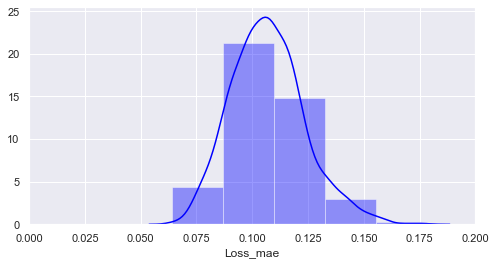

In [66]:
X_pred = model.predict(np.array(X_train_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure(figsize = (8,4))
sns.distplot(scored['Loss_mae'],
             bins = 5, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.2])

In [67]:
# Checando a memória da GPU
!nvidia-smi

Wed Aug 19 19:30:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    31W /  N/A |   7562MiB /  8192MiB |     21%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [68]:
# Parar recuso da memória da GPU
pid = 20936

In [69]:
os.kill(pid,pid)

OSError: [WinError 87] Parâmetro incorreto

In [70]:
X_pred = model.predict(np.array(X_test_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.15
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Data,,,
2017-06-05 00:00:00.002,0.102493,0.15,False
2017-06-05 00:30:00.002,0.095113,0.15,False
2017-06-05 01:00:00.002,0.101514,0.15,False
2017-06-05 01:30:00.002,0.098990,0.15,False
2017-06-05 02:00:00.002,0.111713,0.15,False


In [71]:
X_pred_train = model.predict(np.array(X_train_cnn))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.15
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [72]:
scored_train.head()

,Loss_mae,Threshold,Anomaly
Data,,,
2017-04-01 01:00:00.001,0.131168,0.15,False
2017-04-01 01:30:00.001,0.133905,0.15,False
2017-04-01 02:00:00.001,0.128487,0.15,False
2017-04-01 02:30:00.001,0.130259,0.15,False
2017-04-01 03:00:00.001,0.126110,0.15,False


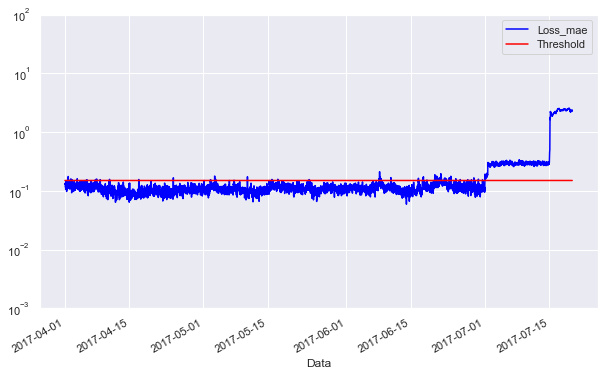

In [73]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e2], color = ['blue','red'])

In [48]:
# Concatenado os dados de treino e teste para comparar com a função gerada pelo modelo
df_TraTes = pd.concat([train,test])

In [49]:
# Realizando o Subset do resultado 
df0 = pd.DataFrame(scored.Loss_mae)

In [50]:
# Agrupando o resultado dos Scores
df_fim = pd.merge(df_TraTes,df0, on=["Data"])
df_fim = df_fim.dropna()

In [51]:
y = df_fim.iloc[:,-1]
X = df_fim.iloc[:,0:27]

In [52]:
# visualisations
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(30, 25)})

In [53]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [54]:
np.random.seed(seed = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.65, random_state = 42)

In [55]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [56]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

R^2 Training Score: 0.95 
OOB Score: 0.65 
R^2 Validation Score: 0.67


In [57]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
#base_imp

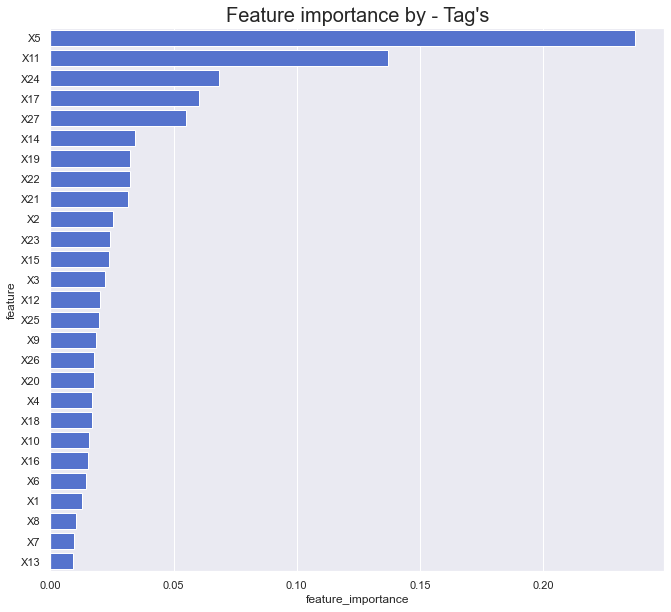

In [58]:
plt.rcParams['figure.figsize'] = [11, 10]
var_imp_plot(base_imp, "Feature importance by - Tag's")